In [ ]:
!pip install ultralytics

In [ ]:
!nvidia-smi

In [40]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_217bc86399661a10f56435977bcbf87a"


In [41]:
import os, json

kaggle_creds = {
    "username": "iroonman",
    "key": "KGAT_217bc86399661a10f56435977bcbf87a"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 600)

print("kaggle.json created successfully")


kaggle.json created successfully


In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip

In [43]:
!unzip -n car-plate-detection.zip


Archive:  car-plate-detection.zip


In [44]:
!rm car-plate-detection.zip

In [45]:
!ls

annotations  data.yaml	runs	     yolo26n.pt
dataset      images	sample_data  yolov8n.pt


In [ ]:
!rm vehicle-detection-image-set.zip

In [47]:
!ls annotations | head

Cars0.xml
Cars100.xml
Cars101.xml
Cars102.xml
Cars103.xml
Cars104.xml
Cars105.xml
Cars106.xml
Cars107.xml
Cars108.xml


In [ ]:
!head -n 5 annotations/*.xml


In [49]:
import os
import xml.etree.ElementTree as ET
from shutil import copyfile
from sklearn.model_selection import train_test_split

IMG_DIR = "images"
ANN_DIR = "annotations"
OUT_DIR = "dataset"

for split in ["train", "val"]:
    os.makedirs(f"{OUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_DIR}/labels/{split}", exist_ok=True)

classes = ["car", "licence"]

def convert_bbox(size, box):
    w, h = size
    xmin, xmax, ymin, ymax = box
    x_center = (xmin + xmax) / 2.0 / w
    y_center = (ymin + ymax) / 2.0 / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return x_center, y_center, bw, bh

xml_files = sorted(os.listdir(ANN_DIR))
train_files, val_files = train_test_split(xml_files, test_size=0.2, random_state=42)

def process(files, split):
    for xml_file in files:
        tree = ET.parse(os.path.join(ANN_DIR, xml_file))
        root = tree.getroot()

        img_name = root.find("filename").text
        img_path = os.path.join(IMG_DIR, img_name)

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        label_path = os.path.join(OUT_DIR, "labels", split, img_name.replace(".png", ".txt"))

        with open(label_path, "w") as f:
            for obj in root.findall("object"):
                cls = obj.find("name").text
                cls_id = classes.index(cls)

                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)

                bb = convert_bbox((w, h), (xmin, xmax, ymin, ymax))
                f.write(f"{cls_id} {' '.join(map(str, bb))}\n")

        copyfile(img_path, os.path.join(OUT_DIR, "images", split, img_name))

process(train_files, "train")
process(val_files, "val")

print("✅ Conversion complete")


✅ Conversion complete


In [ ]:
!ls dataset/images/train | head
!ls dataset/labels/train | head

In [51]:
%%writefile data.yaml
path: dataset
train: images/train
val: images/val

nc: 2
names: ["car", "licence"]


Overwriting data.yaml


In [52]:
!cat data.yaml


path: dataset
train: images/train
val: images/val

nc: 2
names: ["car", "licence"]


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # small & fast
model.train(
    data="data.yaml",
    epochs=30,
    imgsz=640,
    batch=16
)

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
model.predict(source="images/Cars0.png", conf=0.4, save=True)

In [55]:
!ls runs/detect/predict


Cars0.jpg


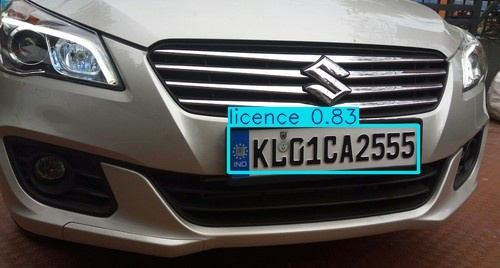

In [56]:
from PIL import Image
Image.open("runs/detect/predict/Cars0.jpg")


In [57]:
import cv2
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
results = model("images/Cars0.png", conf=0.4)

img = cv2.imread("images/Cars0.png")

plate_img = None

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = r.names[cls_id]

        if cls_name == "licence":
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_img = img[y1:y2, x1:x2]


image 1/1 /content/images/Cars0.png: 352x640 1 licence, 9.1ms
Speed: 1.9ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


(np.float64(-0.5), np.float64(189.5), np.float64(46.5), np.float64(-0.5))

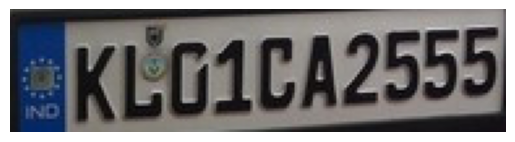

In [58]:
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
plt.axis("off")


In [ ]:
!pip install easyocr
import easyocr
print("EasyOCR installed successfully")

In [60]:
import cv2
import numpy as np

reader = easyocr.Reader(['en'])

# Convert to grayscale
gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharp = cv2.filter2D(gray, -1, kernel)

_, thresh1 = cv2.threshold(sharp, 150, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(sharp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

best_text = ""
best_conf = 0

for img_version in [sharp, thresh1, thresh2]:

    result = reader.readtext(
        img_version,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
        paragraph=False,
        detail=1
    )

    full_text = ""
    confs = []

    for (_, text, prob) in result:
        full_text += text
        confs.append(prob)

    if confs:
        avg_conf = sum(confs) / len(confs)

        if avg_conf > best_conf:
            best_conf = avg_conf
            best_text = full_text

print(f"Plate: {best_text}")
print(f"Confidence: {best_conf}")

Plate: INDKLG1CA2555
Confidence: 0.46423534881233436


In [61]:
import re

text = "INDKLG1CA2555"

# Updated pattern to be more flexible, matching any alphanumeric string
pattern = r'[A-Z0-9]+'
match = re.search(pattern, text)

if match:
    print("Final Plate:", match.group())

Final Plate: INDKLG1CA2555
